# Volume 3: Intro to Deep Learning
    Daniel Perkins
    MATH 405
    12/14/24

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

assert torch.cuda.is_available()

# Problem 1
Create the device variable.
Download the CIFAR10 training and test datasets.
Transform them into tensors and normalize them.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Create the Device

# Create hte transform that also normalizes the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))])

# Load in the dataset
train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


# Problem 2
Split the data into train, validation, and test sets, and create DataLoaders for each one. Use a batch size of 32 for the training set and 1 for the validation and test sets.

In [4]:
# Split the data into training, validation, and test sets
actual_train_data = [train_data[i] for i in range(40_000)]
val_data = [train_data[i] for i in range(40_000, 50_000)]
test_data = test_data

# Create dataloaders for each one
train_loader = DataLoader(actual_train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Problem 3

Create a class for a convolutional neural network that accepts images as $3\times 32 \times 32$ tensors and returns a 1D tensor of length 10, representing its predicted probabilities of each class.

The model should have at least three convolution layers, each followed by an activation function, a max pooling layer, and at least two linear layers.
Choose the size of the layers so that your model has at least 50,000 parameters, and record this calculation in the Jupyter notebook.

In [35]:
class CNN(nn.Module):
  """
  A convolutional neural network that accepts images as 3x32x32 tensors and returns a 1D tensor of length 10, representing its predicted probabilities of each class.
  """
  def __init__(self):
    # Initialize nn.Module
    super().__init__()

    # Create the layers with no parameters
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)

    # Create the layers with parameters
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3) # (3*3^2+1)*8 = 224
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3) # (8*3^2+1)*16 = 1,168
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3) # (16*3^2+1)*32 = 4,640
    self.linear1 = nn.Linear(in_features=32*2*2, out_features=512) # (32*2*2+1)*512 = 66,048
    self.linear2 = nn.Linear(in_features=512, out_features=10)  # (512+1)*10 = 5130

    # The total number of parameters is 224+1168+4460+66048+5130 = 77210

  def forward(self, x):
    # Pass the input through all the layers
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))
    x = self.pool(x)
    x = self.flatten(x)
    x = self.relu(self.linear1(x))
    output = self.linear2(x)  # Don't apply softmax yet (for numerical stability of the loss)
    return output

# Counting the parameters myself gives:
model = CNN()
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 77210


The total number of parameters is 224+1168+4460+66048+5130 = 77,210

# Problem 4
Send your model to the device and instantiate the objective and optimizer.
Train your model with a TQDM display, and calculate the Validation Accuracy after each epoch.
Begin by initializing your TQDM loop, then for each epoch, do the following:

1. Set your model to training mode (model.train())
2. Instantiate an empty loss_list
3. For each batch in train_loader:
    - Send x and y_truth to device
    - Zero out the gradients
    - Use model to predict labels of x
    - Calculate loss between predicted labels and y_truth
    - Append loss (loss.item()) to loss_list
    - Update TQDM loop
    - Backpropagate to compute gradients
    - Optimize and update the weights
4. Save the loss mean as the mean of the losses in loss_list
5. Set your model to evaluation mode (model.eval())
6. Calculate and save validation accuracy
Finish the training by closing your TQDM loop.

Train for 10 epochs, saving the mean loss and validation accuracy for each epoch.
Plot the mean losses and validation accuracies.

Finally, print the final test score.

In [36]:
# Initailize model and set it to training mode
model = CNN()
model.to(device)

objective = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loop = tqdm(total=len(train_loader), position=0)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(10):  # For 10 epochs

    loss_list = []
    acc_list = []
    model.train()

    for x, y_truth in train_loader:  # Extract data
        x, y_truth = x.to(device), y_truth.to(device)
        optimizer.zero_grad()   # Zero out gradient
        y_pred = model(x)  # Make predictions
        loss = objective(y_pred, y_truth)   # Calculate loss
        loss_list.append(loss.item())
        loss.backward()    # Gradient descent step
        optimizer.step()    # Update weights
        # Calcluate the accuracy
        acc = (y_pred.argmax(dim=1) == y_truth).float().mean()
        acc_list.append(acc.item())

    train_losses.append(np.mean(loss_list))   # Append average loss across the epoch
    train_accs.append(np.mean(acc_list))

    loss_list = []
    acc_list = []
    model.eval()

    for x, y_truth in val_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        y_pred = model(x)
        loss = objective(y_pred, y_truth)
        loss_list.append(loss.item())

        acc = (y_pred.argmax(dim=1) == y_truth).float().mean()
        acc_list.append(acc.item())

    val_losses.append(np.mean(loss_list))
    val_accs.append(np.mean(acc_list))

    # Update tqdm
    loop.set_description(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accs[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}')
    loop.update(1)

  0%|          | 0/1250 [00:12<?, ?it/s]
Epoch 10, Training Loss: 0.9792, Training Accuracy: 0.6554, Validation Loss: 1.2087, Validation Accuracy: 0.5911:   1%|          | 10/1250 [02:09<4:25:13, 12.83s/it]

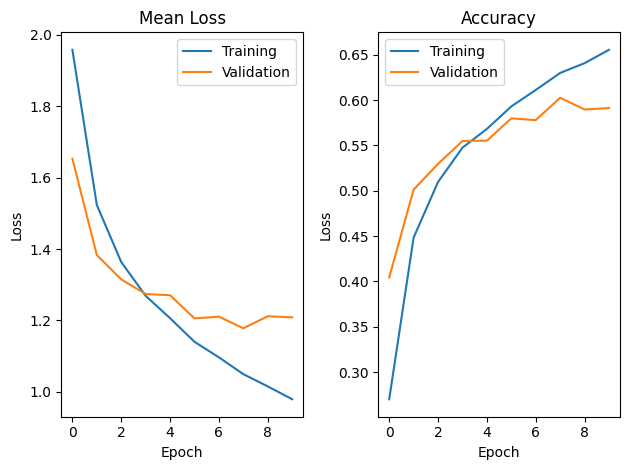

Final test score: 0.5911


In [37]:
# Plot the losses and accuracies
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.title("Mean Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Print the final test score
print("Final test score:", val_accs[-1])

# Problem 5

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [38]:
# FGSM attack code
def fgsm_attack(model, optimizer, objective, x, y, eps):
    """
    Performs the FGSM attack on the given model and data point x with label y.
    Returns the perturbed data point.
    """
    # Calculate the gradient
    x.requires_grad = True
    x.retain_grad()
    optimizer.zero_grad()
    output = model(x)
    loss = objective(output, y)
    loss.backward()
    data_grad = x.grad.data
    # Perturb the images
    x_perturbed = x + eps * data_grad.sign()
    return x_perturbed

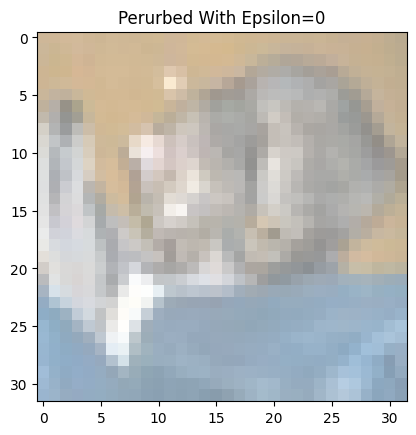

Epsilon: 0, Accuracy: 0.5809


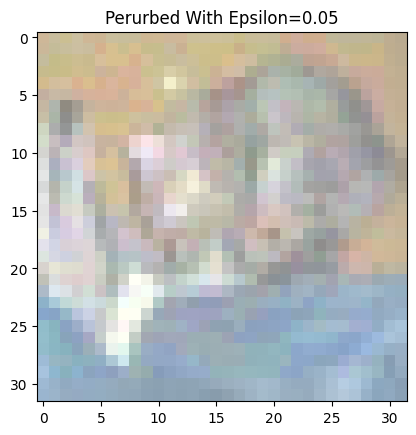

Epsilon: 0.05, Accuracy: 0.0278


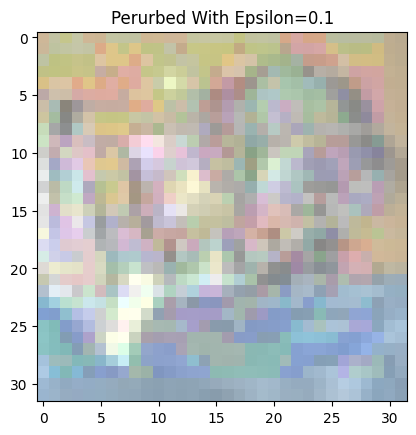

Epsilon: 0.1, Accuracy: 0.0236


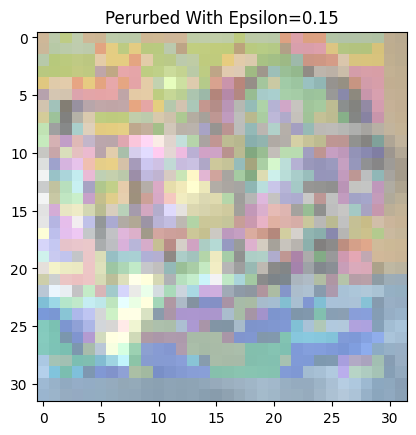

Epsilon: 0.15, Accuracy: 0.0289


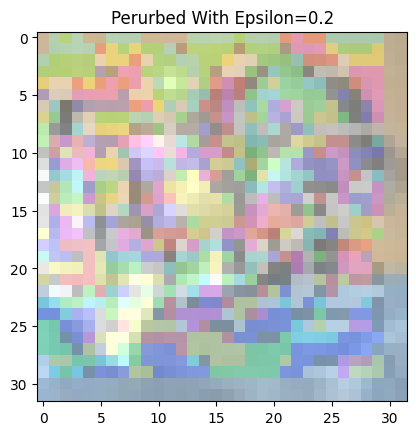

Epsilon: 0.2, Accuracy: 0.0315


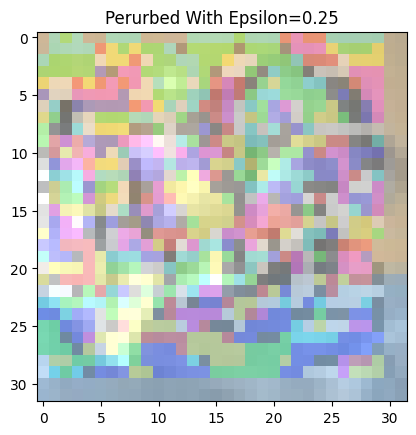

Epsilon: 0.25, Accuracy: 0.0348


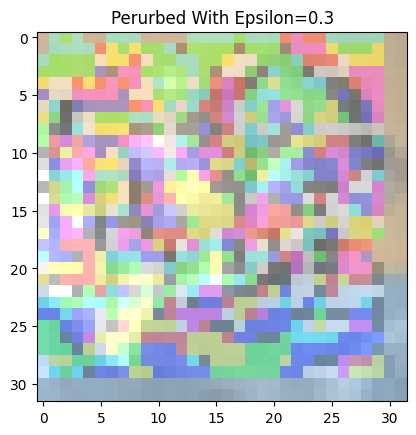

Epsilon: 0.3, Accuracy: 0.0378


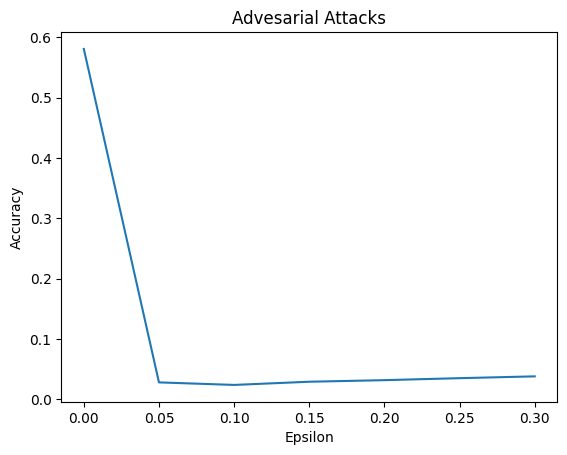

In [47]:
accs = []
epsilon = [0, .05, .1, .15, .2, .25, .3]

for eps in epsilon:  # For each epsilon

  val_accs = []
  model.eval()

  count = 0
  for x, y in test_loader:   # Run through the test data
    x, y = x.to(device), y.to(device)
    x_perturbed = fgsm_attack(model, optimizer, objective, x, y, eps)  # Modify data

    # Display perturbed image if it is the first
    if count == 0:
      ex = x_perturbed.squeeze().detach().cpu().numpy()
      img = ex / 2 + 0.5 # unnormalize
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.title(f'Perurbed With Epsilon={eps}')
      plt.show()

    y_pred = model(x_perturbed)  # Make predictions
    acc = (y_pred.argmax(dim=1) == y).float().mean()  # Calculate accuracy
    val_accs.append(acc.item())  # Append accuracy

    count += 1

  accs.append(np.mean(val_accs))  # Append mean accuracy
  print(f'Epsilon: {eps}, Accuracy: {accs[-1]}')  # Print accuracy

# Plot the accuracy
plt.plot(epsilon, accs)
plt.title("Advesarial Attacks")
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()